In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np
import sklearn
import matplotlib

In [36]:
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("scikit-learn:", sklearn.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", sns.__version__)

pandas: 2.2.3
numpy: 1.26.4
scikit-learn: 1.6.1
matplotlib: 3.10.0
seaborn: 0.13.2


# Perform Extra Data Preprocessing

In [37]:
# Import salary_cleaned.csv.
df = pd.read_csv('salary_cleaned.csv')

df.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary-greater-50k
0,39,State-gov,77516,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40,United-States,False
1,50,Self-emp-not-inc,83311,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13,United-States,False
2,38,Private,215646,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40,United-States,False
3,53,Private,234721,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40,United-States,False
4,28,Private,338409,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40,Cuba,False


In [38]:
# Separate the features and target.
X = df.drop('salary-greater-50k', axis=1)
y = df['salary-greater-50k']

# Identify categorical and numerical columns.
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create preprocessing for categorical features.
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create the preprocessing pipeline.
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols) # Transform the categorical columns.
    ],
    remainder='passthrough'  # Keep the numerical columns as they are.
)

# Fit the preprocessor to the data to access the transformers_ attribute.
preprocessor.fit(X)

# Set the class names.
class_names = ['<=50K', '>50K']
        
# Print the class names and the number of samples in each class.
print(f"Class names: {class_names}")
print(f"Number of samples in each class: {y.value_counts().to_dict()}")

Class names: ['<=50K', '>50K']
Number of samples in each class: {False: 24698, True: 7839}


# Extract Feature Names

In [39]:
# Get categorical and numerical columns.
categorical_cols = list(X.select_dtypes(include=['object', 'category']).columns)
numerical_cols = list(X.select_dtypes(include=['int64', 'float64']).columns)

# Initialise the feature names list.
feature_names = [] 

# Loop through each transformet in the preprocessor to extract feature names.
# The preprocessor has multiple transformers: one for categorical columns and another for numerical columns.
for name, transformer, columns in preprocessor.transformers_:
    if name == 'cat':
        for i, col in enumerate(columns):
            categories = transformer.categories_[i]
            for category in categories:
                feature_names.append(f"{col}_{category}")
    elif name == 'remainder':
        feature_names.extend(numerical_cols)

# Print result of feature name extraction.
print(f"Generated {len(feature_names)} feature names.")

Generated 108 feature names.


# Build Model

In [40]:
# Store the maximum depth of the decision tree.
max_depth = 5
# Store a fixed random seed for reproducability. 
random_state = 42

# Create pipeline.
model = Pipeline(steps=[
        ('preprocessor', preprocessor), # Apply categorical feature transformation using the ColumnTransformer.
        ('classifier', DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)) # Create a Decision Tree classifier.
    ])

# Perform Nested Cross-Validation

In [41]:
# Define the number of splits for the outer and inner cross-validation loops.
n_outer_splits = 5
n_inner_splits = 3

# Define the range of values for max_depth.
max_depth_range = np.arange(1, 11)

# Prepare parameter grid.
param_grid = {
    'classifier__max_depth': max_depth_range
}

# Create pipeline template.
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=random_state))
])

outer_cv = KFold(n_splits=n_outer_splits, shuffle=True, random_state=random_state) # Outer cross-validation.

outer_scores = [] # Store scores from each outer fold.

all_cv_results = [] # Track additional metrics.

# Perform nested cross-validation.
for train_index, test_index in outer_cv.split(X):
    # Split data into training and testing sets for this outer fold.
    X_train_outer, X_test_outer = X.iloc[train_index], X.iloc[test_index]
    y_train_outer, y_test_outer = y.iloc[train_index], y.iloc[test_index]
    
    inner_cv = KFold(n_splits=n_inner_splits, shuffle=True, random_state=random_state) # Inner cross-validation for hyperparameter tuning.
    
    # Grid search with inner cross-validation.
    grid_search = GridSearchCV(
        estimator=pipeline, 
        param_grid=param_grid, 
        cv=inner_cv, 
        scoring='accuracy'
    )
    
    grid_search.fit(X_train_outer, y_train_outer)  # Fit grid search.
    
    best_model = grid_search.best_estimator_ # Best model from inner CV.
    
    # Evaluate on outer test set.
    outer_score = best_model.score(X_test_outer, y_test_outer)
    outer_scores.append(outer_score)
    
    # Store CV results for this fold.
    all_cv_results.append({
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'outer_score': outer_score
    })

# Compute performance metrics
performance = {
'mean_outer_accuracy': np.mean(outer_scores),
'std_outer_accuracy': np.std(outer_scores),
'cv_results': all_cv_results
}
        
# Print results.
print("\nNested Cross-Validation Results:")
print(f"Mean Accuracy: {performance['mean_outer_accuracy']:.4f} ± {performance['std_outer_accuracy']:.4f}")

for i, result in enumerate(performance['cv_results'], 1):
    print(f"\nFold {i}:")
    print(f"  Best Params: {result['best_params']}")
    print(f"  Inner CV Best Score: {result['best_score']:.4f}")
    print(f"  Outer Test Score: {result['outer_score']:.4f}")


Nested Cross-Validation Results:
Mean Accuracy: 0.8558 ± 0.0024

Fold 1:
  Best Params: {'classifier__max_depth': 8}
  Inner CV Best Score: 0.8517
  Outer Test Score: 0.8554

Fold 2:
  Best Params: {'classifier__max_depth': 7}
  Inner CV Best Score: 0.8539
  Outer Test Score: 0.8523

Fold 3:
  Best Params: {'classifier__max_depth': 9}
  Inner CV Best Score: 0.8547
  Outer Test Score: 0.8595

Fold 4:
  Best Params: {'classifier__max_depth': 7}
  Inner CV Best Score: 0.8525
  Outer Test Score: 0.8572

Fold 5:
  Best Params: {'classifier__max_depth': 6}
  Inner CV Best Score: 0.8508
  Outer Test Score: 0.8546


In [42]:
# Use max_depth = 6.
max_depth = 6

# Train Model

In [43]:
# Split the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# Train the model.
model.fit(X_train, y_train)

# Make predictions on the test set.
y_pred = model.predict(X_test)

# Extract the trained decision tree.
tree = model.named_steps['classifier']     

# Plot Decision Tree

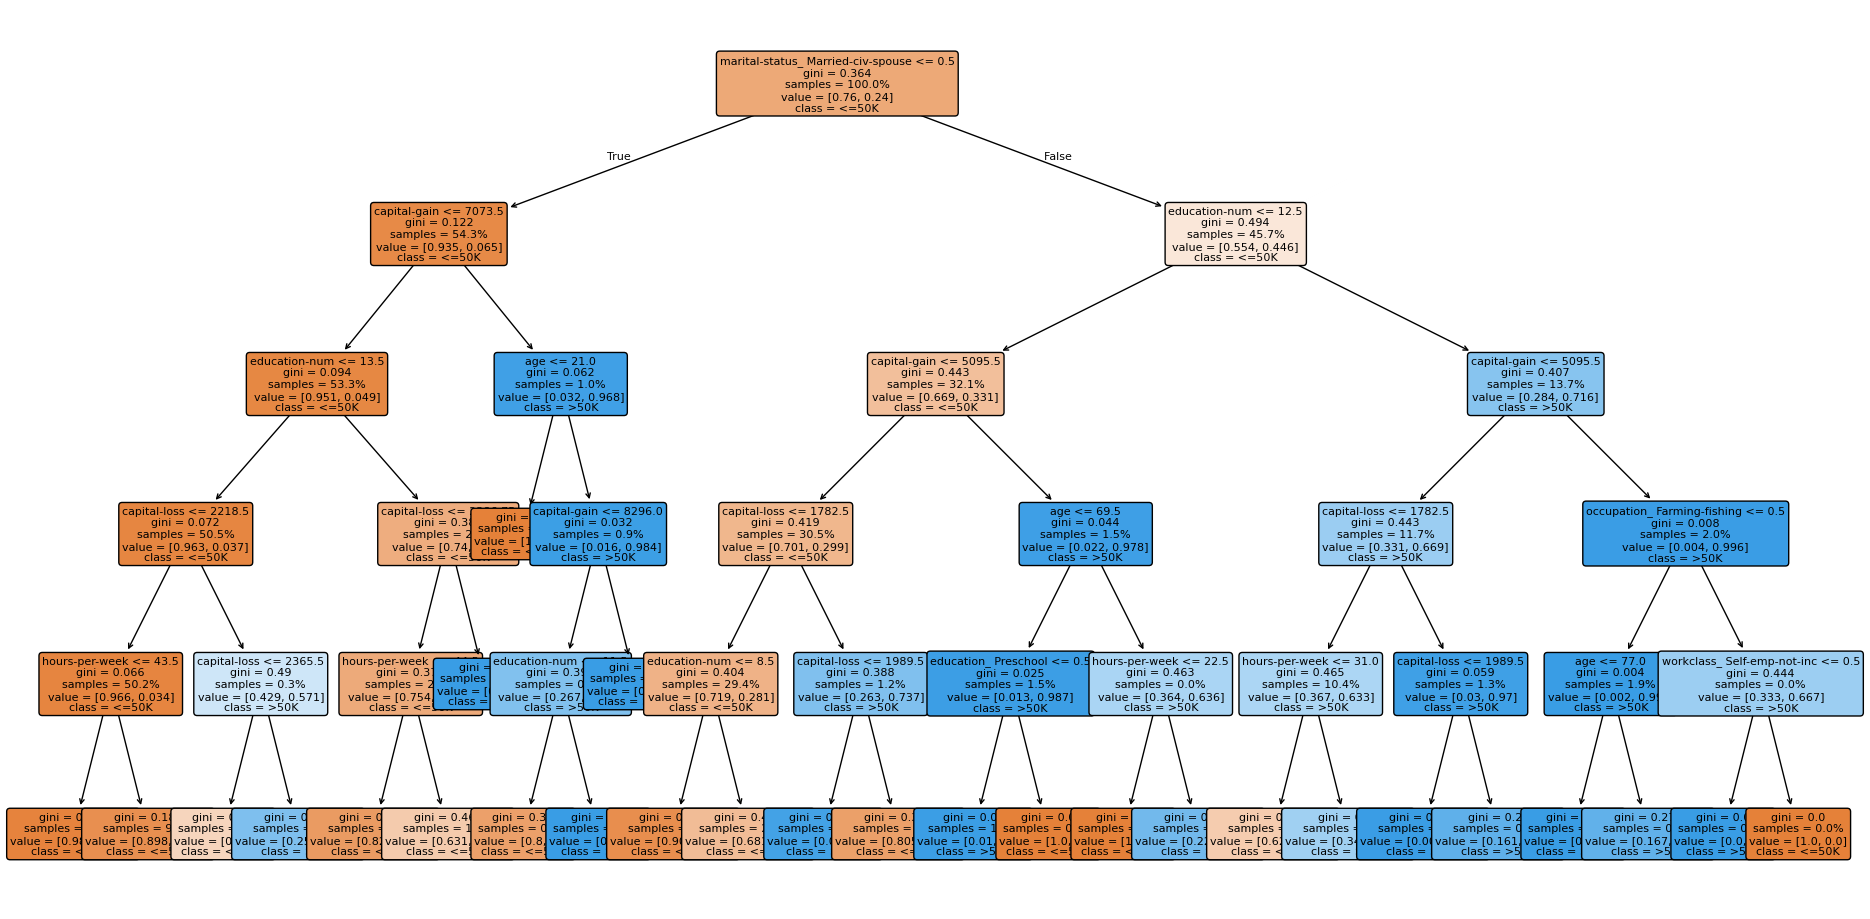

In [44]:
 # Plot and dispay tree for interpretability using visualisation.
plt.figure(figsize=(20, 10))
plot_tree(tree,
          feature_names=feature_names,
          class_names=class_names,
          filled=True,
          rounded=True,
          fontsize=8,
          proportion=True)
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.9, hspace=0.4) # Adjust spacing in between nodes because they initially overlapped.
plt.show()

# Plot Feature Importance


Feature Ranking:
1. marital-status_ Married-civ-spouse (0.4611)
2. education-num (0.2261)
3. capital-gain (0.2107)
4. capital-loss (0.0793)
5. hours-per-week (0.0192)
6. age (0.0026)
7. education_ Preschool (0.0005)
8. workclass_ Self-emp-not-inc (0.0003)
9. occupation_ Farming-fishing (0.0002)
10. workclass_ Federal-gov (0.0000)


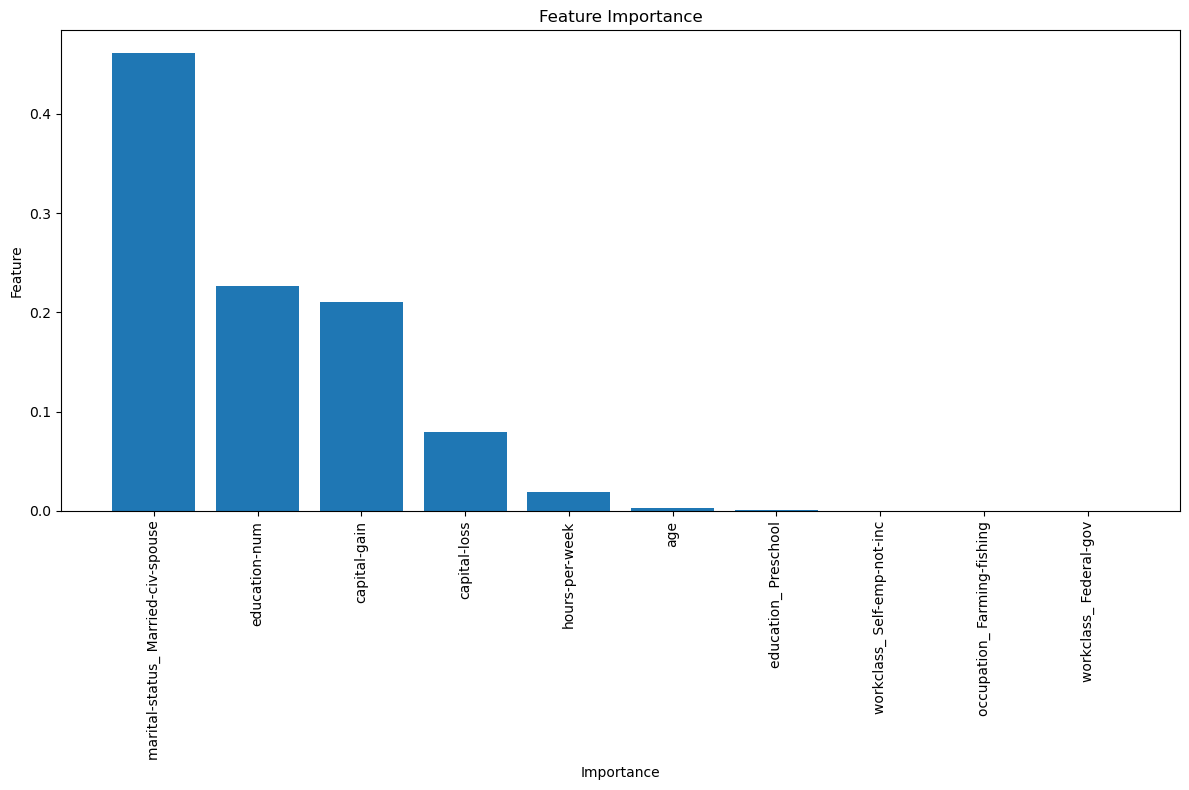

In [45]:
# Get feature importances.
importances = tree.feature_importances_

# Create a list of (feature_name, importance) tuples.
feature_importances = list(zip(feature_names, importances)) 

# Sort by importance.
feature_importances.sort(key=lambda x: x[1], reverse=True) 

 # Create DataFrame for feature importances.
importance_df = pd.DataFrame(feature_importances, columns=['Feature', 'Importance'])

# Display top N features.
print("\nFeature Ranking:")
for i, (feature, importance) in enumerate(feature_importances[:10]):
    print(f"{i+1}. {feature} ({importance:.4f})")

# Plot feature importances.
plt.figure(figsize=(12, 8))

# Create bar chart for further interpretability using visualisation.
plt.bar(range(min(10, len(importance_df))), importance_df['Importance'][:10], align='center')
plt.xticks(range(min(10, len(importance_df))), importance_df['Feature'][:10], rotation=90)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Explain Prediction Using Sample Data

In [46]:
# Create sample data.
sample = {
        'age': 39,
        'workclass': 'State-gov',
        'fnlwgt': 77516,
        'education': 'Bachelors',
        'education-num': 13,
        'marital-status': 'Never-married',
        'occupation': 'Adm-clerical',
        'relationship': 'Not-in-family',
        'race': 'White',
        'sex': 'Male',
        'capital-gain': 2174,
        'capital-loss': 0,
        'hours-per-week': 40,
        'native-country': 'United-States'
    }   

In [47]:
# Convert dictionary to pandas Series.
sample = pd.Series(sample)

# Reshape for a single sample.
sample = sample.to_frame().T if isinstance(sample, pd.Series) else sample 

# Make prediction.
prediction = model.predict(sample)[0] 
# Get probabilities.
probabilities = model.predict_proba(sample)[0]
    
# Get the node indices in the decision path
node_indicator = tree.decision_path(preprocessor.transform(sample))
node_index = node_indicator.indices[node_indicator.indptr[0]:node_indicator.indptr[1]]

# Extract the decision rules.
decision_rules = []
for node_id in node_index:
    # Skip leaf nodes.
    if tree.tree_.children_left[node_id] == tree.tree_.children_right[node_id]:
        continue
        
    # Check the decision at this node.
    feature_id = tree.tree_.feature[node_id]
    threshold = tree.tree_.threshold[node_id]
    feature_name = feature_names[feature_id]
    
    # Determine which path was taken.
    if preprocessor.transform(sample)[0, feature_id] <= threshold:
        decision = f"{feature_name} <= {threshold:.4f}"
        direction = "left"
    else:
        decision = f"{feature_name} > {threshold:.4f}"
        direction = "right"
        
    decision_rules.append({
        'node_id': node_id,
        'feature': feature_name,
        'threshold': float(threshold),
        'decision': decision,
        'direction': direction
    })

# Print explanation.
print("\n")
print(f"Sample: {sample}")
print("\n")
print(f"Prediction: {prediction}")
print(f"Probabilities: {probabilities}")
print("\nDecision Path:")
for rule in decision_rules:
    print(f"Decision: {rule['decision']}")



Sample:   age  workclass fnlwgt  education education-num marital-status    occupation  \
0  39  State-gov  77516  Bachelors            13  Never-married  Adm-clerical   

    relationship   race   sex capital-gain capital-loss hours-per-week  \
0  Not-in-family  White  Male         2174            0             40   

  native-country  
0  United-States  


Prediction: False
Probabilities: [0.98079085 0.01920915]

Decision Path:
Decision: marital-status_ Married-civ-spouse <= 0.5000
Decision: capital-gain <= 7073.5000
Decision: education-num <= 13.5000
Decision: capital-loss <= 2218.5000
Decision: hours-per-week <= 43.5000


# Evaluate Model

In [48]:
# Print the classification report.
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.96      0.91      4905
        True       0.81      0.54      0.65      1603

    accuracy                           0.86      6508
   macro avg       0.84      0.75      0.78      6508
weighted avg       0.85      0.86      0.84      6508



# Plot Confusion Matrix

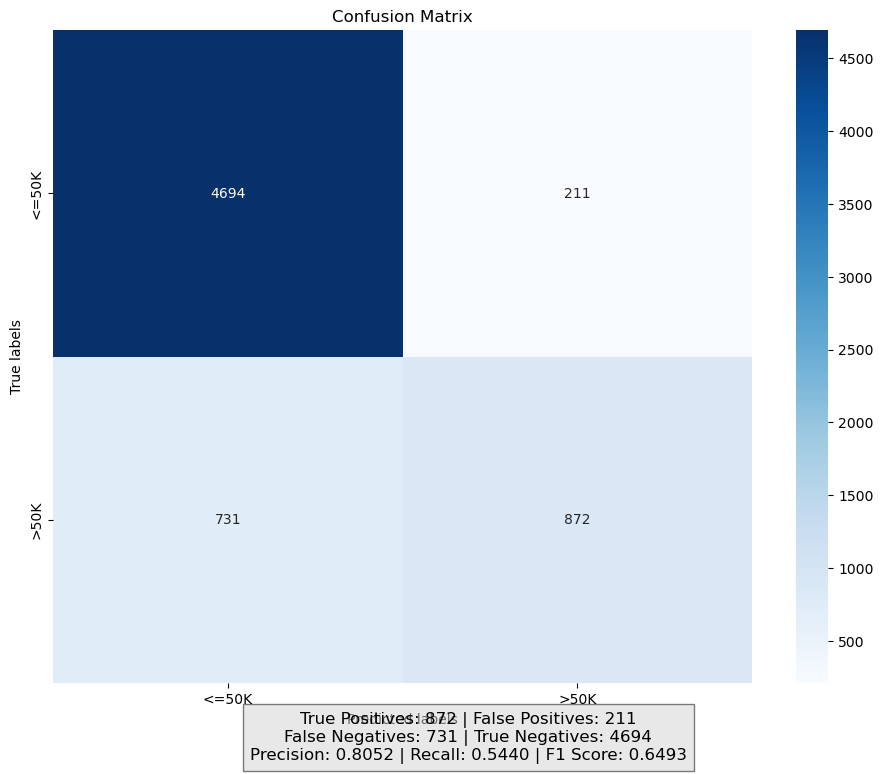

In [49]:
cm = confusion_matrix(y_test, y_pred)
        
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    cm, 
    annot=True,           
    fmt='d',             
    cmap='Blues',         
    xticklabels=class_names,
    yticklabels=class_names,
    ax=ax
)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

tn, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

plt.figtext(0.5, 0.01, 
           f"True Positives: {tp} | False Positives: {fp}\n"
           f"False Negatives: {fn} | True Negatives: {tn}\n"
           f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}", 
           ha="center", fontsize=12, bbox={"facecolor":"lightgrey", "alpha":0.5, "pad":5})

plt.tight_layout(pad=3)
plt.show()